In [1]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
# import shap
# import xgboost as xgb
from sklearn.metrics import precision_recall_curve
import altair as alt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import shap
import altair as alt
import pickle

# Load Data

In [2]:
trainFeatures = pd.read_csv('2016features.csv')

In [4]:
trainLabels = pd.read_csv('2016labels.csv')d

In [12]:
trainLabels = trainLabels.drop(['Unnamed: 0'],axis=1)

In [13]:
trainLabels.head()

,state,DEMOCRAT,REPUBLICAN,OTHER,Total,State Name,demShare,gopShare,indShare,margin
0,ALABAMA,621911.0,1222018.0,0.0,1843929.0,alabama,0.337275,0.662725,0.000000,0.325450
1,ALASKA,111019.0,155088.0,40863.0,306970.0,alaska,0.361661,0.505222,0.133117,0.143561
2,ARIZONA,1034687.0,1264785.0,110700.0,2410172.0,arizona,0.429300,0.524770,0.045930,0.095470
3,ARKANSAS,111347.0,760415.0,196512.0,1068274.0,arkansas,0.104231,0.711816,0.183953,0.607586
4,CALIFORNIA,8624432.0,4682033.0,107553.0,13414018.0,california,0.642942,0.349040,0.008018,-0.293901


In [14]:
train = pd.merge(trainFeatures, trainLabels, on='State Name')

In [15]:
train.head()

,STATE ABV,State Name,state_x,Nike,Costco,Twitter,Facebook,Sears,Wells Fargo,Comcast,...,kraft_trends,state_y,DEMOCRAT,REPUBLICAN,OTHER,Total,demShare,gopShare,indShare,margin
0,AL,alabama,Alabama,0.269375,0.042500,0.077813,0.615313,0.040313,0.225312,0.045312,...,42,ALABAMA,621911.0,1222018.0,0.0,1843929.0,0.337275,0.662725,0.000000,0.325450
1,AZ,arizona,Arizona,0.263402,0.335585,0.069790,0.537217,0.090474,0.230336,0.021809,...,38,ARIZONA,1034687.0,1264785.0,110700.0,2410172.0,0.429300,0.524770,0.045930,0.095470
2,AR,arkansas,Arkansas,0.184299,0.000000,0.076592,0.546673,0.002393,0.023456,0.012446,...,54,ARKANSAS,111347.0,760415.0,196512.0,1068274.0,0.104231,0.711816,0.183953,0.607586
3,CA,california,California,0.250134,0.356383,0.110403,0.536974,0.159893,0.234879,0.124870,...,45,CALIFORNIA,8624432.0,4682033.0,107553.0,13414018.0,0.642942,0.349040,0.008018,-0.293901
4,CO,colorado,Colorado,0.216921,0.308738,0.087656,0.575035,0.137309,0.265187,0.365881,...,44,COLORADO,1263791.0,1288618.0,149029.0,2701438.0,0.467822,0.477012,0.055167,0.009190


In [16]:
Xtrain = train.loc[:, 'Nike':'kraft_trends']
YtrainR = train['gopShare']
train['maskActual'] = train['gopShare'].apply(lambda x: round(x))
YtrainC = train['maskActual']

In [23]:
testFeatures = pd.read_csv('2018features.csv')
testLabels = pd.read_csv('2018labels.csv')
test = pd.merge(testFeatures,testLabels,on='State Name')

In [22]:
testLabels = testLabels.drop(['Unnamed: 0'],axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

In [24]:
Xtest = test.loc[:, 'Nike':'kraft_trends']
YtestR = test['gopShare']
test['maskActual'] = test['gopShare'].apply(lambda x: round(x))
YtestC = test['maskActual']

# Create Dummy Model

In [25]:
dummy_regr = DummyRegressor(strategy="mean").fit(Xtrain,YtrainR)
y_pred = dummy_regr.predict(Xtest)
dummy_regr.score(Xtest, YtestR)

-0.1204553232170682

In [26]:
testDF = pd.DataFrame(columns=['pred','actual','State','maskPred','maskActual'])
testDF['pred'] = y_pred
testDF['actual'] = YtestR
testDF['State'] = test['STATE ABV']

In [27]:
testDF['maskPred'] = testDF['pred'].apply(lambda x: round(x))
testDF['maskActual'] = testDF['actual'].apply(lambda x: round(x))

In [28]:
Counter(testDF['maskPred'])

Counter({1: 48})

In [29]:
Counter(testDF['maskActual'])

Counter({1: 24, 0: 24})

# Linear Regression Model (Classification)

In [14]:
linReg = LinearRegression()

In [15]:
parameters = {
    'normalize' : [True, False],
#     'dual': ['False'],
    'positive' : [True, False],
}

In [16]:
clf = GridSearchCV(linReg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [17]:
%%time
import warnings
warnings.filterwarnings('ignore')
clf.fit(Xtrain,YtrainR)

Wall time: 2.99 s


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'normalize': [True, False], 'positive': [True, False]},
             scoring='accuracy')

In [18]:
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'normalize': True, 'positive': True}


In [19]:
bestLinReg = clf.best_estimator_
bestLinReg.predict(Xtest)

array([1.78731238, 1.88346335, 2.87757451, 1.85488334, 2.8296442 ,
       2.3974299 , 4.09700008, 2.28354808, 2.71954057, 2.33692101,
       1.81597145, 3.27118487, 2.39249059, 1.38717209, 1.70608331,
       1.23979569, 1.22125526, 2.10176613, 1.18239503, 2.08327523,
       1.36849959, 1.92896743, 0.74995519, 1.74116865, 0.91675227,
       3.30499023, 1.69431168, 1.98610791, 2.46681372, 2.07839361,
       2.5710088 , 0.78119281, 1.92641602, 0.98713329, 0.98692656,
       1.88169481, 2.50417644, 1.37287895, 0.24233182, 1.67643909,
       1.90040438, 2.47213048, 0.03365812, 2.29390308, 1.88573541,
       1.81151632, 1.58612839, 1.38403371])

# Logistic Regression Model (Classification)

## Tune Model:

In [30]:
logreg = LogisticRegression()

In [31]:
parameters = [{
    'penalty' : ['l2'],
#     'dual': ['False'],
#     'multi_class' : ['ovr'],
    'tol': [1e-2,1e-3,1e-4,1e-5,1e-6],
    'C'       : np.logspace(-3,3,7),
    'class_weight' : ['balanced','None'],
    'solver'  : ['newton-cg'],
    'max_iter' : [100,150,200,250,300]
},
{
    'penalty' : ['l2'],
#     'dual': ['False'],
#     'multi_class' : ['ovr'],
    'tol': [1e-2,1e-3,1e-4,1e-5,1e-6],
    'C'       : np.logspace(-3,3,7),
    'class_weight' : ['balanced','None'],
    'solver'  : ['lbfgs', 'sag'],
    'max_iter' : [100,150,200,250,300]
},
{
    'penalty' : ['l2','l1'],
    'dual': [True,False],
#     'multi_class' : ['ovr'],
    'tol': [1e-2,1e-3,1e-4,1e-5,1e-6],
    'C'       : np.logspace(-3,3,7),
    'class_weight' : ['balanced','None'],
    'solver'  : ['liblinear'],
    'max_iter' : [100,150,200,250,300]
},
{
    'penalty' : ['l2','l1','elasticnet'],
#     'dual': ['False'],
#     'multi_class' : ['ovr'],
    'tol': [1e-2,1e-3,1e-4,1e-5,1e-6],
    'C'       : np.logspace(-3,3,7),
    'class_weight' : ['balanced','None'],
    'solver'  : ['saga'],
    'max_iter' : [100,150,200,250,300]
}  
]

In [32]:
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [33]:
%%time
import warnings
warnings.filterwarnings('ignore')
clf.fit(Xtrain,YtrainC)

Wall time: 1min 44s


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2'], 'solver': ['newton-cg'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'clas...
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2', 'l1'], 'solver': ['liblinear'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
   

In [34]:
bestLogReg = clf.best_estimator_
bestLogReg

LogisticRegression(C=0.01, class_weight='balanced', solver='newton-cg',
                   tol=0.01)

LogisticRegression(C=0.01, class_weight='balanced', multi_class='ovr',
                   solver='newton-cg', tol=0.01)

In [112]:
filename = 'logRegBase.sav'
pickle.dump(bestLogReg, open(filename, 'wb'))

In [62]:
list(Xtest.columns)

['Nike',
 'Costco',
 'Twitter',
 'Facebook',
 'Sears',
 'Wells Fargo',
 'Comcast',
 'Mcdonalds',
 'United Airlines',
 'Target',
 'Bank of America',
 'Starbucks',
 'Delta',
 'Google',
 'Ebay',
 'State Farm',
 'Verizon',
 'AT&T',
 'Fox',
 'Shell',
 'Ikea',
 'T-Mobile',
 'Best Buy',
 'U.S.A.A',
 "Lowe's",
 'CVS',
 'Disney',
 'Coca-Cola',
 'Johnson & Johnson',
 'Amazon',
 'Kroger',
 'Netflix',
 'Adidas',
 'Microsoft',
 'Walgreens',
 'Sony',
 'UPS',
 'The Home Depot',
 'Hobby Lobby',
 'Samsung',
 'Nestle',
 'Wegmans',
 'Chick-Fil-A',
 'Nordstrom',
 'Kohls',
 'Apple',
 'Jp Morgan Chase',
 'Honda',
 'Pepsi',
 'Allstate',
 'Aldi',
 'American Airlines',
 'Burger King',
 'Dell',
 'Capital one',
 'Charter',
 'Dicks sporting goods',
 'Dish',
 'Dominos',
 'EA',
 'Fedex',
 'Fidelty',
 'Ford',
 'Forever 21',
 'Gamestop',
 'General Mills',
 'Goldman Sachs',
 'Goya',
 'HP',
 'Hulu',
 'Hyundia',
 'Kaiser perminta',
 'kraft',
 'L. L. Bean',
 'LG',
 'Mastercard',
 'MLB',
 'Coors',
 'Nintendo',
 'Papas Joh

In [35]:
print('Train')
print("Accuracy:",bestLogReg.score(Xtrain, YtrainC))

Train
Accuracy: 1.0


In [36]:
print('Test')
print("Accuracy:",bestLogReg.score(Xtest, YtestC))

Test
Accuracy: 0.9375


## Error and Feature Analysis

In [37]:
analysis = test[['STATE ABV','gopShare','demShare','margin','maskActual']]
analysis['pred'] = bestLogReg.predict(Xtest)

In [38]:
errors = []
for i, r in analysis.iterrows():
    a = r['maskActual']
    p = r['pred']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
analysis['errors'] = errors

In [39]:
analysis

,STATE ABV,gopShare,demShare,margin,maskActual,pred,errors
0,AL,0.589774,0.410226,0.179549,1,1,1.0
1,AZ,0.486688,0.503752,-0.017063,0,1,-0.5
2,AR,0.625844,0.352079,0.273765,1,1,1.0
3,CA,0.326102,0.657428,-0.331326,0,0,-1.0
4,CO,0.429581,0.534389,-0.104808,0,0,-1.0
5,CT,0.371429,0.586068,-0.214639,0,0,-1.0
6,DE,0.355460,0.644540,-0.289079,0,0,-1.0
7,FL,0.523462,0.471024,0.052438,1,1,1.0
8,GA,0.522717,0.477283,0.045433,1,1,1.0
9,ID,0.617818,0.348038,0.269780,1,1,1.0


In [30]:
analysis.to_csv('analysis.csv')

In [41]:
explainer = shap.Explainer(bestLogReg, Xtrain)

In [ ]:
explainer = shap.Explainer(bestLogReg, Xtrain)
shap_values = explainer(Xtest)
shap.summary_plot(shap_values)

In [42]:
%%time
shap_values = explainer(Xtest)

Wall time: 3.99 ms


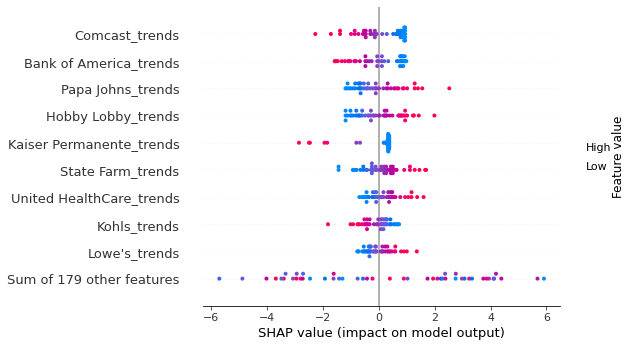

In [43]:
shap.plots.beeswarm(shap_values)

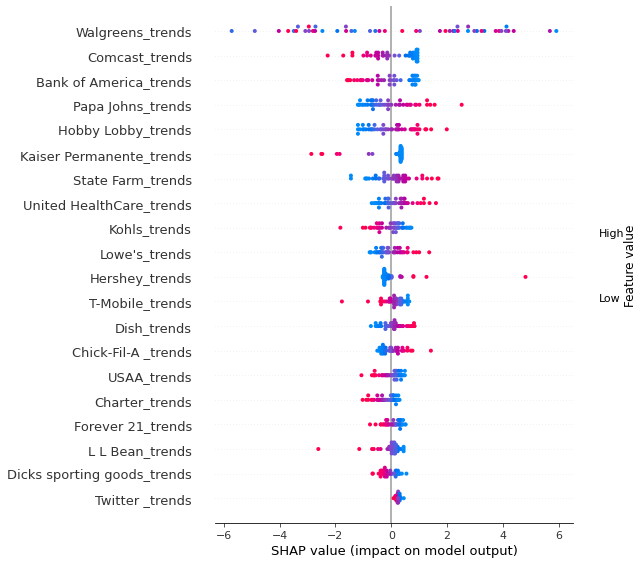

In [44]:
shap.summary_plot(shap_values)

In [45]:
print('CO')
shap.initjs()
shap.plots.force(shap_values[4])

CO


In [56]:
print('PA')
shap.initjs()
shap.plots.force(shap_values[35])

PA


In [40]:
test

,State Name,STATE ABV,state_x,Nike,Costco,Twitter,Facebook,Sears,Wells Fargo,Comcast,...,state_y,DEMOCRAT,REPUBLICAN,OTHER,Total,demShare,gopShare,indShare,margin,maskActual
0,alabama,AL,Alabama,0.261562,0.060937,0.119063,0.534375,0.061562,0.092188,0.036875,...,ALABAMA,678687.0,975737.0,0.0,1654424.0,0.410226,0.589774,0.000000,0.179549,1
1,arizona,AZ,Arizona,0.208668,0.308288,0.055860,0.634726,0.072182,0.317715,0.009990,...,ARIZONA,1179193.0,1139251.0,22378.0,2340822.0,0.503752,0.486688,0.009560,-0.017063,0
2,arkansas,AR,Arkansas,0.148396,0.028243,0.135472,0.762566,0.108186,0.080421,0.089038,...,ARKANSAS,312978.0,556339.0,19625.0,888942.0,0.352079,0.625844,0.022077,0.273765,1
3,california,CA,California,0.263850,0.341307,0.137475,0.499660,0.100412,0.199678,0.107896,...,CALIFORNIA,8010445.0,3973396.0,200681.0,12184522.0,0.657428,0.326102,0.016470,-0.331326,0
4,colorado,CO,Colorado,0.334535,0.328988,0.338974,0.913454,0.104854,0.371983,0.614979,...,COLORADO,1343211.0,1079772.0,90563.0,2513546.0,0.534389,0.429581,0.036030,-0.104808,0
5,connecticut,CT,Connecticut,0.283032,0.173574,0.153737,0.499823,0.121502,0.152320,0.342189,...,CONNECTICUT,808652.0,512495.0,58644.0,1379791.0,0.586068,0.371429,0.042502,-0.214639,0
6,delaware,DE,Delaware,0.560086,0.083691,0.339056,1.034335,0.148069,0.214592,0.860515,...,DELAWARE,227353.0,125384.0,0.0,352737.0,0.644540,0.355460,0.000000,-0.289079,0
7,florida,FL,Florida,0.215499,0.115888,0.129217,0.596662,0.095836,0.200460,0.226469,...,FLORIDA,3307232.0,3675417.0,38715.0,7021364.0,0.471024,0.523462,0.005514,0.052438,1
8,georgia,GA,Georgia,0.293439,0.083033,0.146359,0.649724,0.093006,0.236482,0.232036,...,GEORGIA,1814469.0,1987191.0,0.0,3801660.0,0.477283,0.522717,0.000000,0.045433,1
9,idaho,ID,Idaho,0.192164,0.448383,0.081468,0.745025,0.060323,0.393657,0.041045,...,IDAHO,207303.0,367993.0,20337.0,595633.0,0.348038,0.617818,0.034144,0.269780,1


# Correlation Examination

In [72]:
viz1 = test[['Chick-Fil-A _trends',"gopShare"]]

In [74]:
chart = alt.Chart(test).mark_point().encode(
    x='gopShare:Q',
    y='Chick-Fil-A _trends'
)

chart + chart.transform_regression('x', 'y').mark_line()

alt.Chart(...)

In [75]:
test.to_csv('test.csv')

In [77]:
train.to_csv('train.csv')

In [79]:
Xtrain.to_csv('Xtrain.csv')

In [81]:
trainLabels = train[['gopShare','demShare','margin','maskActual','STATE ABV']]
trainLabels.to_csv('trainLabels.csv')

# Trying only Google Trends Features

## Modify Feature Vectors

In [46]:
trendsTrain = []
consumptionTrain = []
for i in list(Xtrain.columns):
    if "_" in i:
        trendsTrain.append(i)
    else:
        consumptionTrain.append(i)

In [47]:
len(trendsTrain)

94

In [48]:
len(consumptionTrain)

94

In [49]:
XtrendsTrain = Xtrain[trendsTrain]
XconsTrain = Xtrain[consumptionTrain]

In [50]:
trendsTest = []
consumptionTest = []
for i in list(Xtest.columns):
    if "_" in i:
        trendsTest.append(i)
    else:
        consumptionTest.append(i)

In [51]:
len(trendsTest)

94

In [52]:
len(consumptionTest)

94

In [53]:
XtrendsTest = Xtest[trendsTest]
XconsTest = Xtest[consumptionTest]

## Tune and Train

In [54]:
logregTrends = LogisticRegression()

In [55]:
clfTrends = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [56]:
%%time
# import warnings
warnings.filterwarnings('ignore')
clfTrends.fit(XtrendsTrain,YtrainC)

Wall time: 1min 13s


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2'], 'solver': ['newton-cg'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'clas...
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2', 'l1'], 'solver': ['liblinear'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
   

In [57]:
bestLogRegTrends = clfTrends.best_estimator_
bestLogRegTrends

LogisticRegression(C=0.01, class_weight='balanced', solver='newton-cg',
                   tol=0.01)

In [58]:
print('Train')
print("Accuracy:",bestLogRegTrends.score(XtrendsTrain, YtrainC))

Train
Accuracy: 1.0


In [59]:
print('Test')
print("Accuracy:",bestLogRegTrends.score(XtrendsTest, YtestC))

Test
Accuracy: 0.9375


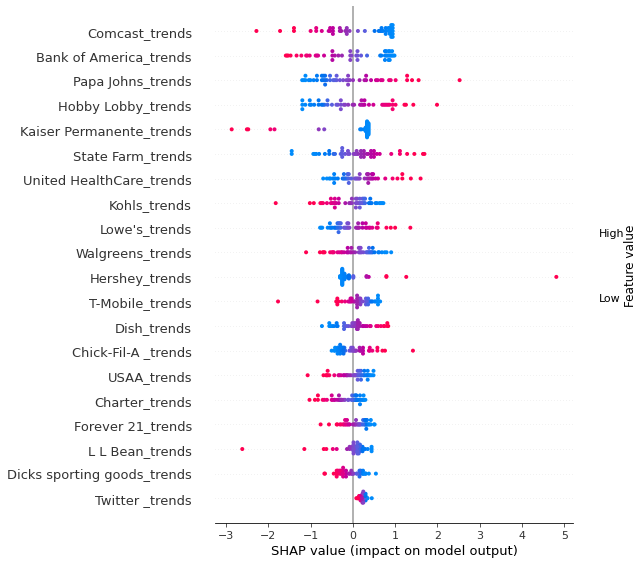

In [60]:
explainer = shap.Explainer(bestLogRegTrends, XtrendsTrain)
shap_values = explainer(XtrendsTest)
shap.summary_plot(shap_values)

In [61]:
print('CO')
shap.initjs()
shap.plots.force(shap_values[4])

CO


In [73]:
analysis = test[['STATE ABV','gopShare','demShare','margin','maskActual']]
analysis['pred'] = bestLogRegTrends.predict(XtrendsTest)
errors = []
for i, r in analysis.iterrows():
    a = r['maskActual']
    p = r['pred']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
analysis['errors'] = errors

In [75]:
analysis.to_csv('Tanalysis.csv')

# Trying only the Consumption Features

In [62]:
logregCons = LogisticRegression()

In [63]:
clfCons = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [64]:
%%time
# import warnings
# warnings.filterwarnings('ignore')
clfCons.fit(XconsTrain,YtrainC)

Wall time: 51.4 s


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2'], 'solver': ['newton-cg'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'clas...
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2', 'l1'], 'solver': ['liblinear'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
   

In [65]:
bestLogRegCons = clfCons.best_estimator_
bestLogRegCons

LogisticRegression(C=0.001, class_weight='balanced', max_iter=200,
                   solver='saga')

In [66]:
print('Train')
print("Accuracy:",bestLogRegCons.score(XconsTrain, YtrainC))

Train
Accuracy: 0.8333333333333334


In [67]:
print('Test')
print("Accuracy:",bestLogRegCons.score(XconsTest, YtestC))

Test
Accuracy: 0.5416666666666666


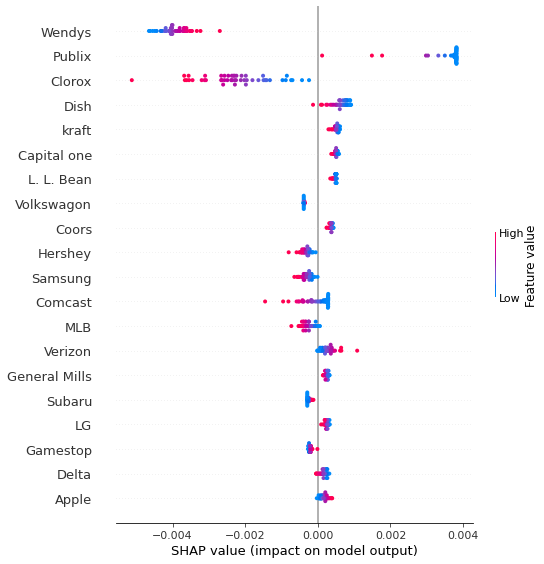

In [69]:
explainer = shap.Explainer(bestLogRegCons, XconsTrain)
shap_values = explainer(XconsTest)
shap.summary_plot(shap_values)

In [70]:
analysis = test[['STATE ABV','gopShare','demShare','margin','maskActual']]
analysis['pred'] = bestLogRegCons.predict(XconsTest)
errors = []
for i, r in analysis.iterrows():
    a = r['maskActual']
    p = r['pred']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
analysis['errors'] = errors

In [72]:
analysis.to_csv('Canalysis.csv')

# Recursive Feature Elimination

In [141]:
rfe = RFE(estimator=LogisticRegression())

In [142]:
%%time
rfe.fit(Xtrain,YtrainC)

Wall time: 976 ms


RFE(estimator=LogisticRegression())

In [148]:
rfe.score(Xtrain,YtrainC)

1.0

In [149]:
rfe.score(Xtest,YtestC)

0.9375

In [147]:
rfe.ranking_

array([38, 41, 67, 14, 30, 54, 15, 33, 89, 52, 69, 93, 29, 21, 92, 42, 70,
       64, 48, 82, 87, 85, 78, 40, 11, 39, 56, 16, 31, 91, 66, 24, 65, 45,
       84, 53, 73, 75, 49, 88, 68, 72, 76, 74, 26, 37, 25, 61, 32, 58, 57,
       62, 20, 35, 59, 63, 27, 36,  7, 55,  1, 50, 13, 83, 44, 47, 71, 81,
       28, 90, 60,  2, 19, 86,  8, 10, 51,  3, 46, 79, 12,  6, 17, 77,  1,
       80, 94, 22, 18, 23, 34, 95,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, 43,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1])

In [157]:
reducedFeatures = rfe.get_feature_names_out(Xtrain.columns)

In [160]:
len(reducedFeatures)

94

In [161]:
for i in list(XtrendsTrain.columns):
    if i not in list(reducedFeatures):
        print(i)

Clorox_trends
Gamestop_trends
Ikea_trends
Target_trends


In [162]:
for i in list(reducedFeatures):
    if i not in list(XtrendsTrain.columns):
        print(i)

Shell
Goya
Clorox
Hershey


In [153]:
len(rfe.get_feature_names_out(Xtrain.columns))

94

In [159]:
len(XtrendsTrain.columns)

94

# RFE on just Google Trends

In [163]:
rfeT = RFE(estimator=LogisticRegression())

In [164]:
%%time
rfeT.fit(XtrendsTrain,YtrainC)

Wall time: 592 ms


RFE(estimator=LogisticRegression())

In [166]:
rfeT.score(XtrendsTrain,YtrainC)

1.0

In [167]:
rfeT.score(XtrendsTest,YtestC)

0.9375

In [169]:
reducedFeaturesT = rfeT.get_feature_names_out(XtrendsTrain.columns)

In [170]:
reducedFeaturesT

array(['AT&T_trends', 'American Airlines_trends', 'Apple_trends',
       'Bank of America_trends', 'Best Buy_trends', 'Capital one_trends',
       'Charter_trends', 'Chick-Fil-A _trends', 'Coca-Cola_trends',
       'Comcast_trends', 'Coors_trends', 'Costco _trends',
       'Dicks sporting goods_trends', 'Dish_trends', 'Disney_trends',
       'Facebook_trends', 'Forever 21_trends', 'General Mills_trends',
       'Goya_trends', 'Hershey_trends', 'Hobby Lobby_trends',
       'Hulu_trends', 'Hyundai_trends', 'Jp Morgan Chase_trends',
       'Kaiser Permanente_trends', 'Kohls_trends', 'L L Bean_trends',
       "Lowe's_trends", 'NBA_trends', 'Nintendo_trends',
       'Papa Johns_trends', 'Publix_trends', 'Samsung_trends',
       'Sears_trends', 'Starbucks_trends', 'State Farm_trends',
       'Subaru_trends', 'T-Mobile_trends', 'Twitter _trends',
       'USAA_trends', 'United HealthCare_trends', 'Verizon_trends',
       'Volkswagon_trends', 'Walgreens_trends', 'Wegmans _trends',
       'Wendy

In [171]:
len(reducedFeaturesT)

47

In [175]:
reducedXtrain = XtrendsTrain[reducedFeaturesT]
reducedXtest = XtrendsTest[reducedFeaturesT]

In [182]:
reducedXtrain

,AT&T_trends,American Airlines_trends,Apple_trends,Bank of America_trends,Best Buy_trends,Capital one_trends,Charter_trends,Chick-Fil-A _trends,Coca-Cola_trends,Comcast_trends,...,T-Mobile_trends,Twitter _trends,USAA_trends,United HealthCare_trends,Verizon_trends,Volkswagon_trends,Walgreens_trends,Wegmans _trends,Wendys_trends,kraft_trends
0,77,22,58,16,77,27,67,60,43,19,...,29,66,57,44,61,55,50,1,38,42
1,31,100,65,80,78,28,14,31,25,8,...,42,73,57,100,49,70,79,1,34,38
2,92,32,57,38,73,26,8,43,24,11,...,13,55,30,34,44,56,59,1,44,54
3,61,42,82,86,84,24,30,14,17,26,...,60,80,31,32,33,63,37,1,25,45
4,37,42,63,19,78,27,25,35,20,61,...,42,61,77,50,43,73,61,1,46,44
5,43,42,80,88,74,31,37,11,21,45,...,26,81,22,44,44,90,41,5,31,48
6,36,51,73,37,84,38,35,36,27,83,...,29,73,46,53,100,82,78,31,37,73
7,57,74,67,98,86,35,25,44,29,49,...,54,67,49,79,35,66,73,2,68,50
8,81,31,63,75,77,30,38,100,100,48,...,40,69,71,54,43,63,45,2,71,38
9,24,16,64,15,66,19,23,17,17,3,...,36,48,34,24,60,85,45,1,30,44


In [183]:
reducedTlogreg = LogisticRegression()

In [184]:
clfRT = GridSearchCV(reducedTlogreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [177]:
%%time
# import warnings
# warnings.filterwarnings('ignore')
clfRT.fit(reducedXtrain,YtrainC)

Wall time: 1min 28s


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2'], 'solver': ['newton-cg'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'clas...
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2', 'l1'], 'solver': ['liblinear'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
   

In [178]:
bestLogRegReduced = clfRT.best_estimator_
bestLogRegReduced

LogisticRegression(C=1000.0, class_weight='balanced', penalty='l1',
                   solver='liblinear', tol=0.01)

In [187]:
print('Train')
print("Accuracy:",bestLogRegReduced.score(reducedXtrain, YtrainC))

Train
Accuracy: 1.0


In [188]:
print('Test')
print("Accuracy:",bestLogRegReduced.score(reducedXtest, YtestC))

Test
Accuracy: 0.9375


In [190]:
explainer = shap.Explainer(bestLogRegReduced, reducedXtest)

In [192]:
%%time
shap_values = explainer(reducedXtest)

Wall time: 1.99 ms


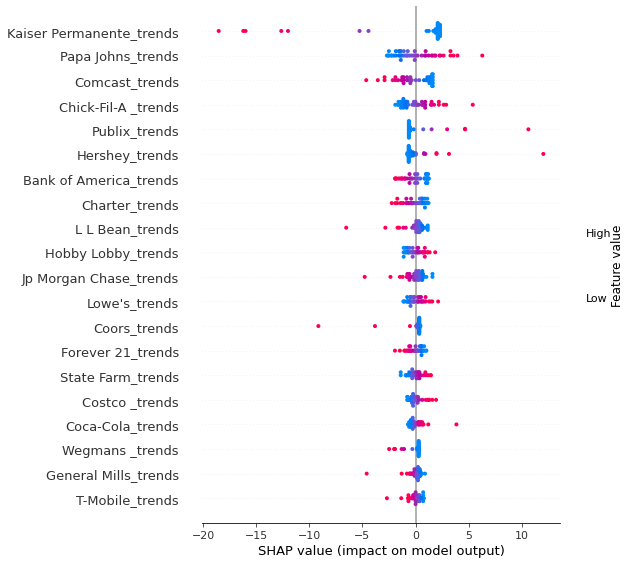

In [193]:
shap.summary_plot(shap_values)

# Reduce to 10

In [91]:
def recursiveOverIter(N,parameters,XtrendsTrain,YtrainC,XtrendsTest,YtestC):
    df = pd.DataFrame(columns=['N','train','test','features'])
    train = []
    test = []
    features = []
    n = []
    for i in range(1,N+1):
        rfeTen = RFE(estimator=LogisticRegression(), n_features_to_select=i)
        rtenlogreg = LogisticRegression()
        rfeTen.fit(XtrendsTrain,YtrainC)
        reducedFeaturesTen = rfeTen.get_feature_names_out(XtrendsTrain.columns)
        reducedXtrainTen = XtrendsTrain[reducedFeaturesTen]
        reducedXtestTen = XtrendsTest[reducedFeaturesTen]
        clfRTen = GridSearchCV(rtenlogreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)
        clfRTen.fit(reducedXtrainTen,YtrainC)
        bestLogRegReducedTen = clfRTen.best_estimator_
        trainAcc = bestLogRegReducedTen.score(reducedXtrainTen, YtrainC)
        testAcc = bestLogRegReducedTen.score(reducedXtestTen, YtestC)
        train.append(trainAcc)
        test.append(testAcc)
        features.append(reducedFeaturesTen)
        n.append(i)
    df['train'] = train
    df['test'] = test
    df['features'] = features
    df['N'] = n
    return df

In [92]:
%%time
rfePlot = recursiveOverIter(10,parameters,XtrendsTrain,YtrainC,XtrendsTest,YtestC)

Wall time: 8min 21s


In [93]:
rfePlot

,N,train,test,features
0,1,0.854167,0.687500,[Apple_trends]
1,2,0.875000,0.833333,"[Apple_trends, Papa Johns_trends]"
2,3,0.895833,0.875000,"[Apple_trends, Kaiser Permanente_trends, Papa ..."
3,4,0.895833,0.875000,"[Apple_trends, Kaiser Permanente_trends, Kohls..."
4,5,0.791667,0.750000,"[Apple_trends, Coors_trends, Kaiser Permanente..."
5,6,0.979167,0.958333,"[Apple_trends, Coors_trends, Dish_trends, Kais..."
6,7,1.000000,0.937500,"[Apple_trends, Coors_trends, Dish_trends, Hers..."
7,8,1.000000,0.937500,"[Apple_trends, Coors_trends, Dish_trends, Hers..."
8,9,1.000000,0.958333,"[Apple_trends, Coors_trends, Dish_trends, Fore..."
9,10,1.000000,0.937500,"[Apple_trends, Coors_trends, Dish_trends, Fore..."


In [98]:
source = pd.melt(rfePlot, id_vars=['N'], value_vars=['train','test'])

In [102]:
source2 = pd.melt(rfePlot, id_vars=['N'], value_vars=['features'])

In [103]:
source2

,N,variable,value
0,1,features,[Apple_trends]
1,2,features,"[Apple_trends, Papa Johns_trends]"
2,3,features,"[Apple_trends, Kaiser Permanente_trends, Papa ..."
3,4,features,"[Apple_trends, Kaiser Permanente_trends, Kohls..."
4,5,features,"[Apple_trends, Coors_trends, Kaiser Permanente..."
5,6,features,"[Apple_trends, Coors_trends, Dish_trends, Kais..."
6,7,features,"[Apple_trends, Coors_trends, Dish_trends, Hers..."
7,8,features,"[Apple_trends, Coors_trends, Dish_trends, Hers..."
8,9,features,"[Apple_trends, Coors_trends, Dish_trends, Fore..."
9,10,features,"[Apple_trends, Coors_trends, Dish_trends, Fore..."


In [105]:
S = pd.merge(source,source2,on='N')

In [106]:
S.head()

,N,variable_x,value_x,variable_y,value_y
0,1,train,0.854167,features,[Apple_trends]
1,1,test,0.687500,features,[Apple_trends]
2,2,train,0.875000,features,"[Apple_trends, Papa Johns_trends]"
3,2,test,0.833333,features,"[Apple_trends, Papa Johns_trends]"
4,3,train,0.895833,features,"[Apple_trends, Kaiser Permanente_trends, Papa ..."


In [111]:
lines = (
    alt.Chart(S)
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x="N",
        y="value_x",
        color="variable_x",
        tooltip = ['value_y','value_x']
    )
).properties(
    title = 'RFE Accuracy per Features Selected',
    width = 450,
    height = 450
)
lines

alt.Chart(...)

In [287]:
rfeTen = RFE(estimator=LogisticRegression(), n_features_to_select=2)

In [288]:
rtenlogreg = LogisticRegression()

In [289]:
%%time
rfeTen.fit(XtrendsTrain,YtrainC)

Wall time: 1.14 s


RFE(estimator=LogisticRegression(), n_features_to_select=2)

In [290]:
reducedFeaturesTen = rfeTen.get_feature_names_out(XtrendsTrain.columns)

In [291]:
reducedFeaturesTen

array(['Apple_trends', 'Papa Johns_trends'], dtype=object)

In [292]:
reducedXtrainTen = XtrendsTrain[reducedFeaturesTen]
reducedXtestTen = XtrendsTest[reducedFeaturesTen]

In [293]:
clfRTen = GridSearchCV(rtenlogreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                  n_jobs = -1)

In [294]:
%%time
# import warnings
# warnings.filterwarnings('ignore')
clfRTen.fit(reducedXtrainTen,YtrainC)

Wall time: 1min 2s


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2'], 'solver': ['newton-cg'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'clas...
                          'max_iter': [100, 150, 200, 250, 300],
                          'penalty': ['l2', 'l1'], 'solver': ['liblinear'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': ['balanced', 'None'],
                          'max_iter': [100, 150, 200, 250, 300],
   

In [295]:
bestLogRegReducedTen = clfRTen.best_estimator_
bestLogRegReducedTen

LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', tol=0.01)

In [296]:
print('Train')
print("Accuracy:",bestLogRegReducedTen.score(reducedXtrainTen, YtrainC))

Train
Accuracy: 0.875


In [297]:
print('Test')
print("Accuracy:",bestLogRegReducedTen.score(reducedXtestTen, YtestC))

Test
Accuracy: 0.8333333333333334


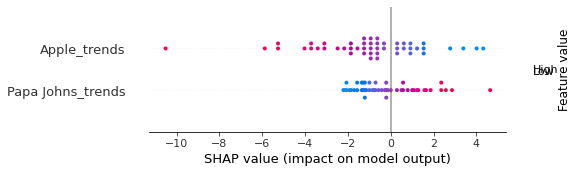

In [298]:
explainer = shap.Explainer(bestLogRegReducedTen, reducedXtrainTen)
shap_values = explainer(reducedXtestTen)
shap.summary_plot(shap_values)